# LangGraph로 만드는 AI 에이전트 실전 입문

## 9.3 Q&A 애플리케이션 실습

In [1]:
!pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 pydantic==2.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 539.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: pydantic-core
    Found ex

In [2]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [3]:
ROLES = {
    "1": {
        "name": "일반 지식 전문가",
        "description": "폭넓은 분야의 일반적인 질문에 답변",
        "details": "폭넓은 분야의 일반적인 질문에 대해 정확하고 이해하기 쉬운 답변을 제공하세요."
    },
    "2": {
        "name": "생성형 AI 제품 전문가",
        "description": "생성형 AI와 관련 제품, 기술에 관한 전문적인 질문에 답변",
        "details": "생성형 AI와 관련 제품, 기술에 관한 전문적인 질문에 대해 최신 정보와 깊은 통찰력을 제공하세요."
    },
    "3": {
        "name": "카운슬러",
        "description": "개인적인 고민이나 심리적인 문제에 대해 지원 제공",
        "details": "개인적인 고민이나 심리적인 문제에 대해 공감적이고 지원적인 답변을 제공하고, 가능하다면 적절한 조언도 해주세요."
    }
}

In [4]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="사용자의 질문")
    current_role: str = Field(
        default="", description="선정된 답변 역할"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="답변 이력"
    )
    current_judge: bool = Field(
        default=False, description="품질 체크 결과"
    )
    judgement_reason: str = Field(
        default="", description="품질 체크 판정 이유"
    )

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
# 나중에 max_tokens 값을 변경할 수 있도록 변경 가능한 필드 선언
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))

In [7]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
"""질문을 분석하고 가장 적합한 답변 담당 역할을 선택하세요.

선택지:
{role_options}

답변은 선택지의 번호(1, 2, 또는 3)만 반환하세요.

질문: {query}
""".strip()
    )
    # 선택지의 번호만 반환하기를 기대하므로 max_tokens 값을 1로 변경
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}

In [8]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
"""당신은 {role}로서 답변하세요. 다음 질문에 대해 당신의 역할에 기반한 적절한 답변을 제공하세요.

역할 상세:
{role_details}

질문: {query}

답변:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

In [9]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="판정 결과")
    reason: str = Field(default="", description="판정 이유")

def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
"""다음 답변의 품질을 체크하고, 문제가 있으면 'False', 문제가 없으면 'True'로 답변하세요.
또한, 그 판정 이유도 설명하세요.

사용자의 질문: {query}
답변: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
    }

In [10]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [11]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [12]:
# selection 노드에서 처리 시작
workflow.set_entry_point("selection")

In [13]:
# selection 노드에서 answering 노드로
workflow.add_edge("selection", "answering")
# answering 노드에서 check 노드로
workflow.add_edge("answering", "check")

In [14]:
from langgraph.graph import END

# check 노드에서 다음 노드로의 전환에 조건부 엣지 정의
# state.current_judge 값이 True면 END 노드로, False면 selection 노드로
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

In [15]:
compiled = workflow.compile()

In [16]:
initial_state = State(query="생성형 AI에 관해 알려주세요")
result = compiled.invoke(initial_state)

In [17]:
result

{'query': '생성형 AI에 관해 알려주세요',
 'current_role': '생성형 AI 제품 전문가',
 'messages': ['생성형 AI에 대해 설명드리겠습니다.\n\n생성형 AI는 인공지능의 한 분야로, 주어진 데이터를 기반으로 새로운 콘텐츠를 생성하는 기술을 말합니다. 이 기술은 텍스트, 이미지, 음악, 코드 등 다양한 형태의 데이터를 생성할 수 있습니다. 생성형 AI의 대표적인 예로는 OpenAI의 GPT-3와 같은 자연어 처리 모델이 있으며, 이는 주어진 텍스트 입력에 따라 자연스럽고 일관된 문장을 생성할 수 있습니다.\n\n생성형 AI의 작동 원리는 주로 대량의 데이터를 학습하여 패턴을 인식하고, 이를 바탕으로 새로운 데이터를 생성하는 것입니다. 이러한 모델은 딥러닝 기술을 활용하여 복잡한 데이터 구조를 이해하고, 이를 통해 창의적인 결과물을 만들어냅니다.\n\n생성형 AI는 다양한 산업에서 활용되고 있습니다. 예를 들어, 콘텐츠 제작에서는 자동으로 기사를 작성하거나, 소설의 초안을 생성하는 데 사용됩니다. 또한, 디자인 분야에서는 새로운 이미지나 그래픽을 생성하는 데 활용되며, 음악 산업에서는 새로운 곡을 작곡하는 데 도움을 줄 수 있습니다.\n\n이 기술은 창의적인 작업을 지원하고, 반복적인 작업을 자동화하여 효율성을 높이는 데 큰 기여를 하고 있습니다. 그러나 생성형 AI의 사용에는 윤리적인 고려도 필요합니다. 생성된 콘텐츠의 저작권 문제나, 잘못된 정보의 확산 가능성 등을 주의 깊게 다루어야 합니다.\n\n생성형 AI는 앞으로도 계속 발전할 것이며, 다양한 분야에서 혁신적인 변화를 가져올 것으로 기대됩니다. 이 기술을 이해하고 적절히 활용하는 것이 중요합니다. 추가적인 질문이 있거나 특정 분야에 대한 더 깊은 정보가 필요하시면 언제든지 말씀해 주세요.'],
 'current_judge': True,
 'judgement_reason': '답변은 생성형 AI에 대한 전반적인 설명을 잘 제공하고 있습니다. 생성형 AI의 정의, 작동

In [18]:
print(result["messages"][-1])

생성형 AI에 대해 설명드리겠습니다.

생성형 AI는 인공지능의 한 분야로, 주어진 데이터를 기반으로 새로운 콘텐츠를 생성하는 기술을 말합니다. 이 기술은 텍스트, 이미지, 음악, 코드 등 다양한 형태의 데이터를 생성할 수 있습니다. 생성형 AI의 대표적인 예로는 OpenAI의 GPT-3와 같은 자연어 처리 모델이 있으며, 이는 주어진 텍스트 입력에 따라 자연스럽고 일관된 문장을 생성할 수 있습니다.

생성형 AI의 작동 원리는 주로 대량의 데이터를 학습하여 패턴을 인식하고, 이를 바탕으로 새로운 데이터를 생성하는 것입니다. 이러한 모델은 딥러닝 기술을 활용하여 복잡한 데이터 구조를 이해하고, 이를 통해 창의적인 결과물을 만들어냅니다.

생성형 AI는 다양한 산업에서 활용되고 있습니다. 예를 들어, 콘텐츠 제작에서는 자동으로 기사를 작성하거나, 소설의 초안을 생성하는 데 사용됩니다. 또한, 디자인 분야에서는 새로운 이미지나 그래픽을 생성하는 데 활용되며, 음악 산업에서는 새로운 곡을 작곡하는 데 도움을 줄 수 있습니다.

이 기술은 창의적인 작업을 지원하고, 반복적인 작업을 자동화하여 효율성을 높이는 데 큰 기여를 하고 있습니다. 그러나 생성형 AI의 사용에는 윤리적인 고려도 필요합니다. 생성된 콘텐츠의 저작권 문제나, 잘못된 정보의 확산 가능성 등을 주의 깊게 다루어야 합니다.

생성형 AI는 앞으로도 계속 발전할 것이며, 다양한 분야에서 혁신적인 변화를 가져올 것으로 기대됩니다. 이 기술을 이해하고 적절히 활용하는 것이 중요합니다. 추가적인 질문이 있거나 특정 분야에 대한 더 깊은 정보가 필요하시면 언제든지 말씀해 주세요.


In [19]:
initial_state = State(query="생성형 AI에 관해 알려주세요")
result = await compiled.ainvoke(initial_state)
result

{'query': '생성형 AI에 관해 알려주세요',
 'current_role': '생성형 AI 제품 전문가',
 'messages': ['생성형 AI에 대해 설명드리겠습니다.\n\n생성형 AI는 인공지능의 한 분야로, 주어진 데이터를 기반으로 새로운 콘텐츠를 생성하는 기술을 말합니다. 이 기술은 텍스트, 이미지, 음악, 비디오 등 다양한 형태의 콘텐츠를 생성할 수 있습니다. 생성형 AI의 대표적인 예로는 OpenAI의 GPT-3와 같은 언어 모델이 있으며, 이는 자연어 처리(NLP) 기술을 활용하여 사람과 유사한 방식으로 텍스트를 생성할 수 있습니다.\n\n생성형 AI의 작동 원리는 주로 대량의 데이터를 학습하여 패턴을 인식하고, 이를 바탕으로 새로운 데이터를 생성하는 것입니다. 예를 들어, 텍스트 생성 AI는 방대한 양의 문서를 학습하여 문법, 어휘, 문장 구조 등을 이해하고, 이를 바탕으로 새로운 문장을 만들어냅니다.\n\n이 기술은 다양한 산업에서 활용되고 있습니다. 예를 들어, 마케팅 분야에서는 광고 카피나 소셜 미디어 콘텐츠를 자동으로 생성하는 데 사용되며, 엔터테인먼트 분야에서는 음악이나 예술 작품을 창작하는 데 활용됩니다. 또한, 고객 서비스에서는 챗봇을 통해 사용자와의 대화를 자동화하는 데 사용되기도 합니다.\n\n생성형 AI는 창의적인 작업을 자동화하고, 인간의 작업을 보조하는 데 큰 잠재력을 가지고 있지만, 윤리적인 문제와 데이터의 편향성 등 해결해야 할 과제도 존재합니다. 따라서 이러한 기술을 개발하고 활용할 때는 책임감 있는 접근이 필요합니다.\n\n이와 관련하여 더 궁금한 점이 있거나 특정 분야에서의 활용 사례에 대해 알고 싶으시면 언제든지 질문해 주세요.'],
 'current_judge': True,
 'judgement_reason': '답변은 생성형 AI에 대한 전반적인 설명을 잘 제공하고 있으며, 기술의 작동 원리, 활용 사례, 그리고 윤리적 문제까지 포괄적으로 다루고 있습니다. 사용자의 질문에 적절하고 충분한 정보를 제공하

In [20]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 30 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

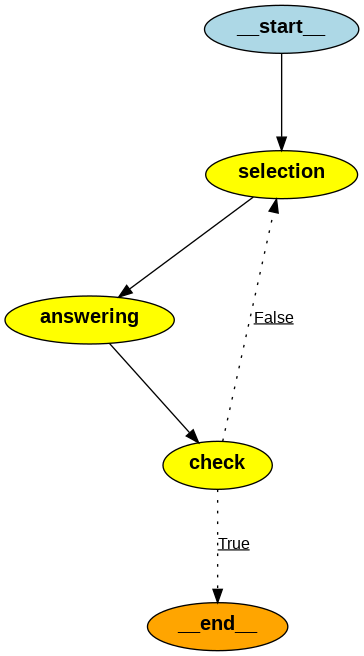

In [21]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

## 9.4 체크포인트 기능: 상태의 영속화와 재개

In [22]:
!pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 langgraph-checkpoint==1.0.11

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 1.0.12
    Uninstalling langgraph-checkpoint-1.0.12:
      Successfully uninstalled langgraph-checkpoint-1.0.12


In [23]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [24]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# 그래프의 상태 정의
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# 메시지를 추가하는 노드 함수
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="당신은 최소한의 응답을 하는 대화 에이전트입니다.")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

# LLM에서의 응답을 추가하는 노드 함수
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

In [25]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("체크포인트 데이터:")
    pprint(checkpoint_tuple.checkpoint)
    print("\n메타데이터:")
    pprint(checkpoint_tuple.metadata)

In [26]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# 그래프 설정
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# 체크포인터 설정
checkpointer = MemorySaver()

# 그래프 컴파일
compiled_graph = graph.compile(checkpointer=checkpointer)

In [27]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.',
 'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='알겠습니다. 찹쌀떡을 좋아하시는군요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 45, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'stop', 'logprobs': None}, id='run-c6378842-7f79-4602-b324-3ed6a93a360f-0', usage_metadata={'input_tokens': 45, 'output_tokens': 17, 'total_tokens': 62})]}

In [28]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f01688c-c655-69ab-8002-e519a612c670'}}, checkpoint={'v': 1, 'ts': '2025-04-11T03:55:24.904264+00:00', 'id': '1f01688c-c655-69ab-8002-e519a612c670', 'channel_values': {'query': '제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', 'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}), HumanMessage(content='제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', additional_kwargs={}, response_metadata={}), AIMessage(content='알겠습니다. 찹쌀떡을 좋아하시는군요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 45, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reaso

In [29]:
print_checkpoint_dump(checkpointer, config)

체크포인트 데이터:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='알겠습니다. 찹쌀떡을 좋아하시는군요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 45, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'stop', 'logprobs': None}, id='run-c6378842-7f79-4602-b324-3ed6a93a360f-0', usage_metadata={'input_tokens': 45, 'output_tokens': 17, 'total_tokens': 62})],
     

In [30]:
user_query = State(query="제가 좋아하는 것이 뭔지 기억나세요?")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '제가 좋아하는 것이 뭔지 기억나세요?',
 'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='알겠습니다. 찹쌀떡을 좋아하시는군요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 45, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'stop', 'logprobs': None}, id='run-c6378842-7f79-4602-b324-3ed6a93a360f-0', usage_metadata={'input_tokens': 45, 'output_tokens': 17, 'total_tokens': 62}),
  HumanMessage(content='제가 좋아하는 것이 뭔지 기억나세요?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='네, 

In [31]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f01688d-edf8-61e1-8006-4d8b48c912d1'}}, checkpoint={'v': 1, 'ts': '2025-04-11T03:55:55.903820+00:00', 'id': '1f01688d-edf8-61e1-8006-4d8b48c912d1', 'channel_values': {'query': '제가 좋아하는 것이 뭔지 기억나세요?', 'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}), HumanMessage(content='제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', additional_kwargs={}, response_metadata={}), AIMessage(content='알겠습니다. 찹쌀떡을 좋아하시는군요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 45, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'st

In [32]:
print_checkpoint_dump(checkpointer, config)

체크포인트 데이터:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='제가 좋아하는 것은 찹쌀떡입니다. 기억해 주세요.', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='알겠습니다. 찹쌀떡을 좋아하시는군요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 45, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'stop', 'logprobs': None}, id='run-c6378842-7f79-4602-b324-3ed6a93a360f-0', usage_metadata={'input_tokens': 45, 'output_tokens': 17, 'total_tokens': 62}),
      

In [33]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="제가 좋아하는 것은 뭔가요?")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '제가 좋아하는 것은 뭔가요?',
 'messages': [SystemMessage(content='당신은 최소한의 응답을 하는 대화 에이전트입니다.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='제가 좋아하는 것은 뭔가요?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='잘 모르겠어요. 좋아하는 것을 말씀해 주실 수 있나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 38, 'total_tokens': 55, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'stop', 'logprobs': None}, id='run-7c1a30e8-f086-4cb3-bc67-053403b2dad4-0', usage_metadata={'input_tokens': 38, 'output_tokens': 17, 'total_tokens': 55})]}